# Try adding in the empirical relation as a prior instead

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pickle
import os

Lets read in a handful of modes

In [2]:
locs = np.genfromtxt('../locs.txt')
mid = int(np.floor(len(locs)/2))
l0s = locs[mid:mid+1,0]
l1s = locs[mid:mid+1,1]
l2s = locs[mid-1:mid,2]
modelocs = np.append(l0s, l2s)
modeids = [0]*len(l0s)  + [2]*len(l2s)

# l0s = locs[:,0]
# l1s = locs[:,1]
# l2s = locs[:,2]
modelocs = np.array([l0s, l1s, l2s]).flatten()
modeids = [0]*len(l0s)  + [1]*len(l1s) + [2]*len(l2s)

In [3]:
ff = np.genfromtxt('../freqs.txt')
pp = np.genfromtxt('../model.txt')
sel = [(ff >= np.min(modelocs)-25) & (ff <= np.max(modelocs+25))]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

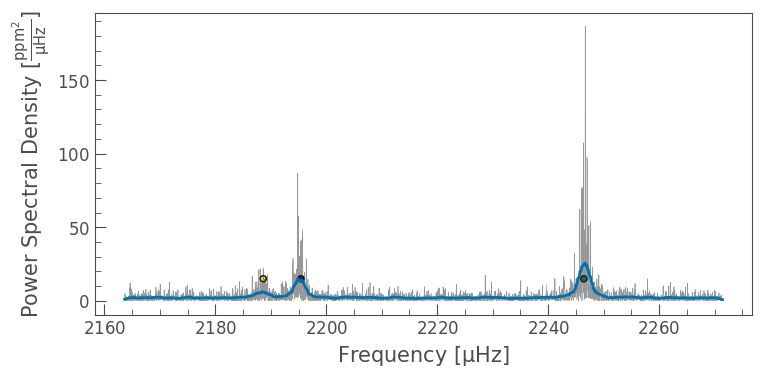

In [4]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

## Lets calculate the GP prior values for these linewidths

In [5]:
code = '''
functions {
    real G (real loc, real Gamma_alpha, real alpha, 
            real DeltaDip, real Wdip, real nudip, real numax){
        return exp((alpha * log(loc/numax) + log(Gamma_alpha))+
                (log(DeltaDip)) / 
                (1+((2*log(loc/nudip))/(log(Wdip/numax)))^2));
    }
}

data {
    int N;
    real locs[N]; // The mode frequencies
    vector[N] lw; // The mode linewidths
}
parameters {
    real alpha;
    real Gamma_alpha;
    real DeltaDip;
    real Wdip;
    real nudip;
    real numax;
}
model {
    real lwmodel[N];
    for (n in 1:N){
        lwmodel[n] = G(locs[n], Gamma_alpha, alpha, 
                    DeltaDip, Wdip, nudip, numax);
    }
                     
    alpha ~ normal(1, 100);
    Gamma_alpha ~ normal(1, 100);
    DeltaDip ~ normal(1, 100);
    Wdip ~ normal(1, 100);
    nudip ~ normal(1, 100);
    numax ~ normal(1, 100);
    
    lw ~ normal(lwmodel, .1);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ef9631a049620dd79fdd87ac2d56c3b NOW.


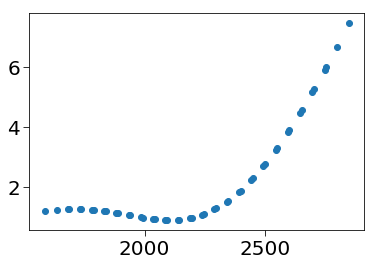

In [6]:
lws = np.genfromtxt('../lws.txt')
plt.scatter(locs.flatten(), lws.flatten())
plt.show()

In [7]:
data = {'N':len(locs.flatten()),
       'locs':locs.flatten(),
       'lw':lws.flatten()}

init = {'alpha' : 3.33,
    'Gamma_alpha' : 5.47,
    'DeltaDip' : 0.18,
    'Wdip' : 3187.,
    'nudip' : 2181.,
    'numax': 2200.}

fit = sm.sampling(data=data, iter=20000, chains=4, 
                  init=[init for x in range(4)])

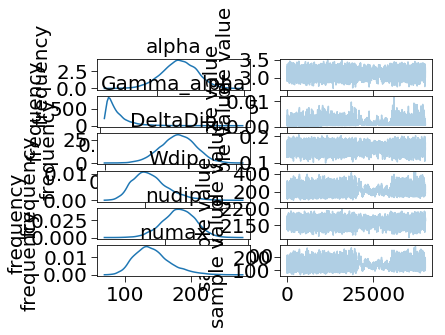

Inference for Stan model: anon_model_5ef9631a049620dd79fdd87ac2d56c3b.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha         3.13  2.3e-3    0.1   2.93   3.06   3.13    3.2   3.32   1890    1.0
Gamma_alpha 1.4e-3  3.5e-5 9.4e-4 4.2e-4 7.2e-4 1.1e-3 1.7e-3 3.9e-3    718   1.01
DeltaDip      0.16  3.0e-4   0.01   0.13   0.15   0.16   0.16   0.18   1947    1.0
Wdip        212.59    1.79   40.7 147.88 183.58 207.37 235.66 307.65    516   1.01
nudip       2158.5    0.23   9.81 2138.6 2152.1 2158.8 2165.3 2177.1   1900    1.0
numax       141.62     1.2  27.67  97.13 122.02 138.21 157.25 206.09    530   1.01
lp__        -241.7    0.05   2.06 -246.6 -242.9 -241.4 -240.2 -238.6   1410    1.0

Samples were drawn using NUTS at Fri May 24 15:30:32 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is 

In [8]:
fit.plot()
plt.show()
print(fit)

In [9]:
def get_Gamma(nunlm, alpha, Gamma_alpha, DeltaDip, Wdip, nudip, numax):
    lnG = (alpha * np.log(nunlm/numax) + np.log(Gamma_alpha)) +\
            (np.log(DeltaDip)) / \
            (1 + ((2*np.log(nunlm/nudip))/(np.log(Wdip/numax)))**2)
    return np.exp(lnG)

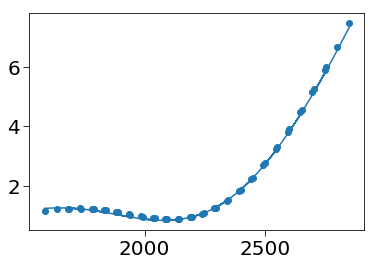

In [10]:
plt.scatter(locs.flatten(), lws.flatten())
plt.plot(data['locs'], get_Gamma(data['locs'],
         np.median(fit['alpha']), 
             np.median(fit['Gamma_alpha']), 
                 np.median(fit['DeltaDip']), 
                     np.median(fit['Wdip']), 
                         np.median(fit['nudip']), 
                             np.median(fit['numax'])))
plt.show()

Now lets try and use this alpha and rho when fitting

In [11]:
model = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
    real G (real loc, real Gamma_alpha, real alpha, 
            real DeltaDip, real Wdip, real nudip, real numax){
        return exp((alpha * log(loc/numax) + log(Gamma_alpha))+
                (log(DeltaDip)) / 
                (1+((2*log(loc/nudip))/(log(Wdip/numax)))^2));
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    vector[N] f;      // Frequency
    vector[N] p;      // Power
    real locs[M];     // Mode locations
    int ids[M];       // The ID's of the modes
    
    real alpha;
    real Gamma_alpha;
    real DeltaDip;
    real Wdip;
    real nudip;
    real numax;

}
parameters{
    real logAmp[M];         // Mode amplitude in log space
    real logGamma[M];       // Mode linewidth in log space
    real<lower=0> vsini;    //  Sin of angle of inclination x rotational splitting
    real<lower=0> vcosi;    //  Cos of angle of inclination x rotational splitting
    real<lower=0> b;        // Background
}
transformed parameters{
    real H[M];                // Mode height
    vector[M] w;     // Mode linewidth
    real i;          // Angle of inclination (rad)
    real<lower=0> nus;     // Rotational frequency splitting
    
    nus = sqrt(vsini^2 + vcosi^2); //Calculate the splitting
    i = acos(vcosi / nus);         // Calculate the inclination
    
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform log linewidth to linewidth    
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector[N] modes; // Our Model
    matrix[4,4] eps; // Matrix of legendre polynomials
    real nus_mu = 0.5; 
    real Gmod[M];
    int l;              
    
    // First we'll calculate all the legendre polynomials for this i
    eps = rep_matrix(1., 4, 4);
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

    
    // Generating our model
    modes = rep_vector(b, N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = ids[mode];    // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1.);
    nus_mu ~ normal(nus, 1.);
    vsini ~ uniform(0,nus);
    
    for (m in 1:M){
        Gmod[m] =  G(locs[m], Gamma_alpha, alpha, 
                    DeltaDip, Wdip, nudip, numax);
    }
    
    w ~ normal(Gmod, 1.);
    
    b ~ normal(1.,.1);
}
'''
sm = pystan.StanModel(model_code = model)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f6be23739bb84dc3f07e7d1232cc336 NOW.


In [12]:
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
dnu = 102. #uHz

data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'locs':modelocs,
        'ids':modeids,
        'alpha':np.median(fit['alpha']), 
        'Gamma_alpha':np.median(fit['Gamma_alpha']), 
        'DeltaDip':np.median(fit['DeltaDip']), 
        'Wdip':np.median(fit['Wdip']), 
        'nudip':np.median(fit['nudip']), 
        'numax':np.median(fit['numax'])}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'logGamma': np.zeros(len(modelocs)),
        'vsini' : nus*np.sin(i),
        'vcosi' : nus*np.cos(i),
        'i' : i,
        'nus': nus,
        'b':1.}

In [13]:
nchains = 4
fit = sm.sampling(data=data, iter=1000, chains=nchains, seed=1895,
                  init = [init for n in range(nchains)])

In [14]:
print(fit)

Inference for Stan model: anon_model_3f6be23739bb84dc3f07e7d1232cc336.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]      1.9  1.1e-3   0.05   1.81   1.87    1.9   1.94   1.99   1786    1.0
logAmp[2]     2.18  1.1e-3   0.04    2.1   2.15   2.18   2.21   2.27   1478    1.0
logAmp[3]     1.51  1.7e-3   0.07   1.36   1.46   1.51   1.56   1.64   1699    1.0
logGamma[1]   0.13  1.8e-3   0.07  -0.02   0.09   0.14   0.18   0.27   1725    1.0
logGamma[2]   0.15  1.8e-3   0.06 6.4e-3    0.1   0.15   0.19   0.26   1332    1.0
logGamma[3]   0.28  3.5e-3   0.12   0.01    0.2   0.28   0.36   0.49   1147    1.0
vsini         0.18  4.8e-3   0.14 4.8e-3   0.06   0.16   0.28   0.47    825    1.0
vcosi         0.51    0.01   0.57 3.3e-3   0.09   0.29   0.73   2.04   1610    1.0
b             1.88  8.8e-4   0.04   1.81   1.85   1.88    1.9   1.

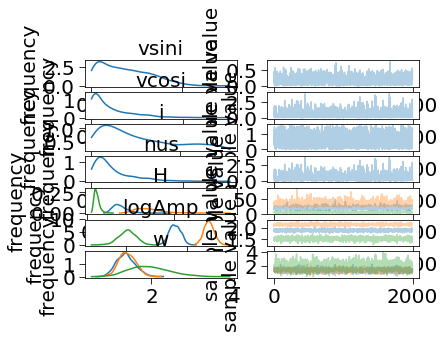

In [15]:
fit.plot(pars=['vsini','vcosi','i','nus','H','logAmp','w'])
plt.show()

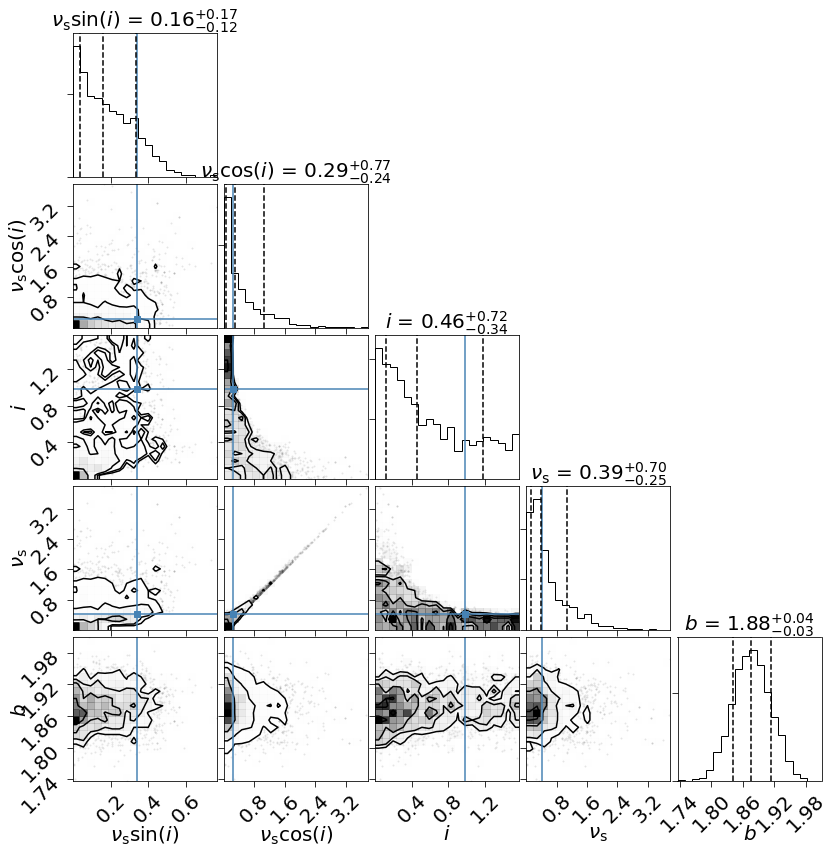

l = 0


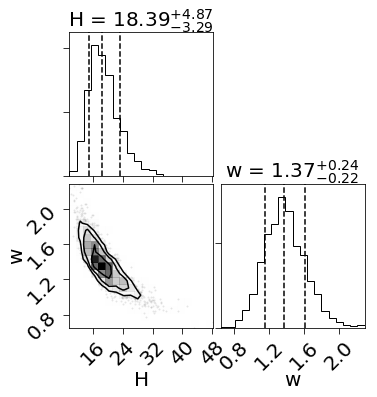

l = 1


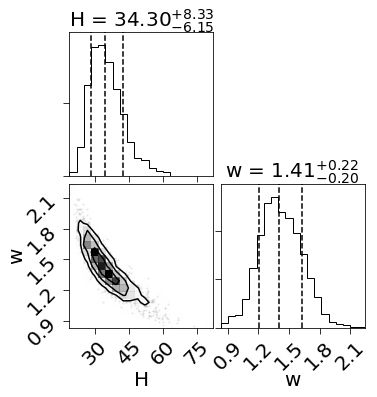

l = 2


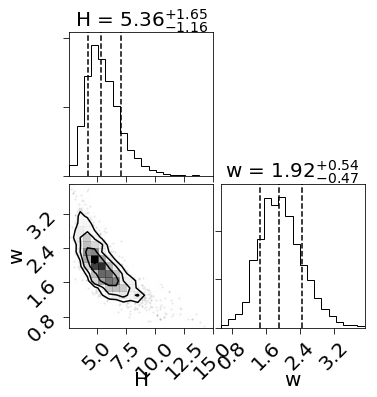

In [16]:
truths= [init['vsini'],init['vcosi'],init['i'],init['nus'], np.nan]
labels=['vsini','vcosi','i','nus', 'b']
chain = np.array([fit[label] for label in labels])
verbose = [r'$\nu_{\rm s}\sin(i)$',r'$\nu_{\rm s}\cos(i)$',r'$i$',
            r'$\nu_{\rm s}$', r'$b$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

for idx in range(len(fit['H'].T)):
    chain = np.array([fit['H'].T[idx], fit['w'].T[idx]])
    corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
    print('l = {}'.format(modeids[idx]))   
    plt.show()

In [17]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
nus = np.median(fit['nus'])
for mode in range(len(modeids)):
    l = modeids[mode]
    for m in range(-l, l+1):
        loc = data['locs'][mode]
        H = np.median(fit['H'].T[mode])
        w = np.median(fit['w'].T[mode])
        model += lorentzian(f, l, m, loc, i, H, w, nus)
fitlocs = data['locs']

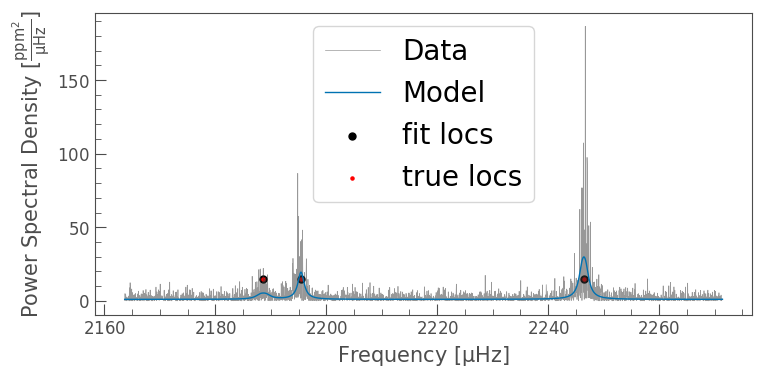

In [18]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data')
plt.scatter(fitlocs, [15]*len(fitlocs),c='k',s=25, label='fit locs')
plt.scatter(modelocs, [15]*len(modelocs),c='r',s=5, label='true locs')
plt.plot(f, model, linewidth=1, label='Model')
plt.legend()